In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
data_path = '/tf/data/ADReSS-IS2020'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [4]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
size_sec = 30
stride_sec = 1

In [7]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')

In [8]:
def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    
    resampled_waveform = tfio.audio.resample(
        waveform, 44100, 16000, name=None
    )
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)
        
    return rolling_waveform_tensors, label

In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .map(lambda x,y: (vggish(x),y))\
                        .cache()\
                        .prefetch(1000)\
                        .shuffle(1000)
    return output_ds

In [10]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


In [11]:
for waveform, y in train_ds.take(1):
    input_shape = waveform.shape
    print(input_shape)
    print(y)

(86, 128)
tf.Tensor(28, shape=(), dtype=int64)


In [12]:
batch_size = 128
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [13]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

In [14]:
print('Input shape:', input_shape)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0],input_shape[1])),
    norm_layer,
    layers.Dense(256,  activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.LSTM(128, 
                activation='tanh', 
                recurrent_activation='sigmoid', 
                recurrent_dropout=0,
                unroll=False,
                use_bias=True,
                kernel_initializer='he_normal', 
                return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64,
                activation='tanh', 
                recurrent_activation='sigmoid', 
                recurrent_dropout=0,
                unroll=False,
                use_bias=True,
                kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(1)
])

model.summary()

Input shape: (86, 128)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 86, 128)           0         
_________________________________________________________________
normalization (Normalization (None, 86, 128)           257       
_________________________________________________________________
dense (Dense)                (None, 86, 256)           33024     
_________________________________________________________________
dropout (Dropout)            (None, 86, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 86, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (Non

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse',
    metrics='mse'
)

In [16]:
EPOCHS = 10000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/10000
1/1 [==============================] - 37s 37s/step - loss: 608.9354 - mse: 608.9354 - val_loss: 574.6593 - val_mse: 574.6593
Epoch 2/10000
1/1 [==============================] - 0s 120ms/step - loss: 591.4404 - mse: 591.4404 - val_loss: 560.9148 - val_mse: 560.9148
Epoch 3/10000
1/1 [==============================] - 0s 122ms/step - loss: 577.1701 - mse: 577.1701 - val_loss: 548.9226 - val_mse: 548.9226
Epoch 4/10000
1/1 [==============================] - 0s 118ms/step - loss: 565.4528 - mse: 565.4528 - val_loss: 536.5770 - val_mse: 536.5770
Epoch 5/10000
1/1 [==============================] - 0s 115ms/step - loss: 553.3168 - mse: 553.3168 - val_loss: 523.7312 - val_mse: 523.7312
Epoch 6/10000
1/1 [==============================] - 0s 123ms/step - loss: 541.0367 - mse: 541.0367 - val_loss: 511.8730 - val_mse: 511.8730
Epoch 7/10000
1/1 [==============================] - 0s 122ms/step - loss: 527.9200 - mse: 527.9200 - val_loss: 500.5478 - val_mse: 500.5478
Epoch 8/10000


Epoch 59/10000
1/1 [==============================] - 0s 105ms/step - loss: 183.8791 - mse: 183.8791 - val_loss: 144.7749 - val_mse: 144.7749
Epoch 60/10000
1/1 [==============================] - 0s 112ms/step - loss: 154.9289 - mse: 154.9289 - val_loss: 140.7793 - val_mse: 140.7793
Epoch 61/10000
1/1 [==============================] - 0s 108ms/step - loss: 154.6270 - mse: 154.6270 - val_loss: 136.8242 - val_mse: 136.8242
Epoch 62/10000
1/1 [==============================] - 0s 111ms/step - loss: 154.4803 - mse: 154.4803 - val_loss: 132.9055 - val_mse: 132.9055
Epoch 63/10000
1/1 [==============================] - 0s 112ms/step - loss: 147.5855 - mse: 147.5855 - val_loss: 129.0332 - val_mse: 129.0332
Epoch 64/10000
1/1 [==============================] - 0s 114ms/step - loss: 160.2977 - mse: 160.2977 - val_loss: 125.2134 - val_mse: 125.2134
Epoch 65/10000
1/1 [==============================] - 0s 193ms/step - loss: 157.5984 - mse: 157.5984 - val_loss: 121.4546 - val_mse: 121.4546
Epoch 

Epoch 118/10000
1/1 [==============================] - 0s 108ms/step - loss: 88.6800 - mse: 88.6800 - val_loss: 43.0161 - val_mse: 43.0161
Epoch 119/10000
1/1 [==============================] - 0s 108ms/step - loss: 92.3244 - mse: 92.3244 - val_loss: 43.0633 - val_mse: 43.0633
Epoch 120/10000
1/1 [==============================] - 0s 112ms/step - loss: 71.8971 - mse: 71.8971 - val_loss: 43.0941 - val_mse: 43.0941
Epoch 121/10000
1/1 [==============================] - 0s 111ms/step - loss: 73.9667 - mse: 73.9667 - val_loss: 43.1508 - val_mse: 43.1508
Epoch 122/10000
1/1 [==============================] - 0s 117ms/step - loss: 68.6342 - mse: 68.6342 - val_loss: 43.1845 - val_mse: 43.1845
Epoch 123/10000
1/1 [==============================] - 0s 116ms/step - loss: 90.5308 - mse: 90.5308 - val_loss: 43.2401 - val_mse: 43.2401
Epoch 124/10000
1/1 [==============================] - 0s 115ms/step - loss: 74.9521 - mse: 74.9521 - val_loss: 43.2649 - val_mse: 43.2649
Epoch 125/10000
1/1 [======

Epoch 177/10000
1/1 [==============================] - 0s 112ms/step - loss: 81.0350 - mse: 81.0350 - val_loss: 44.0511 - val_mse: 44.0511
Epoch 178/10000
1/1 [==============================] - 0s 110ms/step - loss: 78.3064 - mse: 78.3064 - val_loss: 43.9518 - val_mse: 43.9518
Epoch 179/10000
1/1 [==============================] - 0s 109ms/step - loss: 75.2772 - mse: 75.2772 - val_loss: 43.8710 - val_mse: 43.8710
Epoch 180/10000
1/1 [==============================] - 0s 116ms/step - loss: 82.2791 - mse: 82.2791 - val_loss: 43.8340 - val_mse: 43.8340
Epoch 181/10000
1/1 [==============================] - 0s 111ms/step - loss: 82.5356 - mse: 82.5356 - val_loss: 43.7960 - val_mse: 43.7960
Epoch 182/10000
1/1 [==============================] - 0s 108ms/step - loss: 75.5439 - mse: 75.5439 - val_loss: 43.7181 - val_mse: 43.7181
Epoch 183/10000
1/1 [==============================] - 0s 110ms/step - loss: 71.1688 - mse: 71.1688 - val_loss: 43.6570 - val_mse: 43.6570
Epoch 184/10000
1/1 [======

Epoch 236/10000
1/1 [==============================] - 0s 120ms/step - loss: 66.3456 - mse: 66.3456 - val_loss: 43.7559 - val_mse: 43.7559
Epoch 237/10000
1/1 [==============================] - 0s 121ms/step - loss: 72.0898 - mse: 72.0898 - val_loss: 43.5342 - val_mse: 43.5342
Epoch 238/10000
1/1 [==============================] - 0s 203ms/step - loss: 66.6673 - mse: 66.6673 - val_loss: 43.3462 - val_mse: 43.3462
Epoch 239/10000
1/1 [==============================] - 0s 115ms/step - loss: 88.3632 - mse: 88.3632 - val_loss: 43.2787 - val_mse: 43.2787
Epoch 240/10000
1/1 [==============================] - 0s 119ms/step - loss: 84.3058 - mse: 84.3058 - val_loss: 43.2292 - val_mse: 43.2292
Epoch 241/10000
1/1 [==============================] - 0s 117ms/step - loss: 70.8692 - mse: 70.8692 - val_loss: 43.2387 - val_mse: 43.2387
Epoch 242/10000
1/1 [==============================] - 0s 110ms/step - loss: 85.9627 - mse: 85.9627 - val_loss: 43.4012 - val_mse: 43.4012
Epoch 243/10000
1/1 [======

Epoch 295/10000
1/1 [==============================] - 0s 115ms/step - loss: 58.8340 - mse: 58.8340 - val_loss: 45.7090 - val_mse: 45.7090
Epoch 296/10000
1/1 [==============================] - 0s 108ms/step - loss: 80.1365 - mse: 80.1365 - val_loss: 46.7501 - val_mse: 46.7501
Epoch 297/10000
1/1 [==============================] - 0s 119ms/step - loss: 59.8008 - mse: 59.8008 - val_loss: 45.4231 - val_mse: 45.4231
Epoch 298/10000
1/1 [==============================] - 0s 112ms/step - loss: 54.5854 - mse: 54.5854 - val_loss: 45.3527 - val_mse: 45.3527
Epoch 299/10000
1/1 [==============================] - 0s 116ms/step - loss: 58.3039 - mse: 58.3039 - val_loss: 45.8317 - val_mse: 45.8317
Epoch 300/10000
1/1 [==============================] - 0s 115ms/step - loss: 46.9059 - mse: 46.9059 - val_loss: 47.9933 - val_mse: 47.9933
Epoch 301/10000
1/1 [==============================] - 0s 107ms/step - loss: 68.3940 - mse: 68.3940 - val_loss: 50.4248 - val_mse: 50.4248
Epoch 302/10000
1/1 [======

Epoch 354/10000
1/1 [==============================] - 0s 116ms/step - loss: 44.4305 - mse: 44.4305 - val_loss: 54.3709 - val_mse: 54.3709
Epoch 355/10000
1/1 [==============================] - 0s 113ms/step - loss: 55.9329 - mse: 55.9329 - val_loss: 68.1334 - val_mse: 68.1334
Epoch 356/10000
1/1 [==============================] - 0s 123ms/step - loss: 53.9588 - mse: 53.9588 - val_loss: 75.8470 - val_mse: 75.8470
Epoch 357/10000
1/1 [==============================] - 0s 118ms/step - loss: 36.3606 - mse: 36.3606 - val_loss: 73.7114 - val_mse: 73.7114
Epoch 358/10000
1/1 [==============================] - 0s 105ms/step - loss: 45.0683 - mse: 45.0683 - val_loss: 73.8563 - val_mse: 73.8563
Epoch 359/10000
1/1 [==============================] - 0s 116ms/step - loss: 39.3279 - mse: 39.3279 - val_loss: 71.7777 - val_mse: 71.7777
Epoch 360/10000
1/1 [==============================] - 0s 114ms/step - loss: 38.2405 - mse: 38.2405 - val_loss: 70.4130 - val_mse: 70.4130
Epoch 361/10000
1/1 [======

Epoch 413/10000
1/1 [==============================] - 0s 117ms/step - loss: 28.1063 - mse: 28.1063 - val_loss: 66.4838 - val_mse: 66.4838
Epoch 414/10000
1/1 [==============================] - 0s 197ms/step - loss: 37.4989 - mse: 37.4989 - val_loss: 70.9406 - val_mse: 70.9406
Epoch 415/10000
1/1 [==============================] - 0s 116ms/step - loss: 36.5626 - mse: 36.5626 - val_loss: 73.3881 - val_mse: 73.3881
Epoch 416/10000
1/1 [==============================] - 0s 112ms/step - loss: 33.8271 - mse: 33.8271 - val_loss: 77.4352 - val_mse: 77.4352
Epoch 417/10000
1/1 [==============================] - 0s 115ms/step - loss: 42.5469 - mse: 42.5469 - val_loss: 72.8935 - val_mse: 72.8935
Epoch 418/10000
1/1 [==============================] - 0s 118ms/step - loss: 39.9260 - mse: 39.9260 - val_loss: 66.7166 - val_mse: 66.7166
Epoch 419/10000
1/1 [==============================] - 0s 112ms/step - loss: 35.9578 - mse: 35.9578 - val_loss: 64.0369 - val_mse: 64.0369
Epoch 420/10000
1/1 [======

Epoch 472/10000
1/1 [==============================] - 0s 118ms/step - loss: 26.2146 - mse: 26.2146 - val_loss: 59.6392 - val_mse: 59.6392
Epoch 473/10000
1/1 [==============================] - 0s 109ms/step - loss: 29.5367 - mse: 29.5367 - val_loss: 61.5502 - val_mse: 61.5502
Epoch 474/10000
1/1 [==============================] - 0s 117ms/step - loss: 40.0764 - mse: 40.0764 - val_loss: 66.9858 - val_mse: 66.9858
Epoch 475/10000
1/1 [==============================] - 0s 122ms/step - loss: 39.2941 - mse: 39.2941 - val_loss: 72.5161 - val_mse: 72.5161
Epoch 476/10000
1/1 [==============================] - 0s 118ms/step - loss: 31.3806 - mse: 31.3806 - val_loss: 76.7114 - val_mse: 76.7114
Epoch 477/10000
1/1 [==============================] - 0s 109ms/step - loss: 39.4790 - mse: 39.4790 - val_loss: 77.3142 - val_mse: 77.3142
Epoch 478/10000
1/1 [==============================] - 0s 110ms/step - loss: 32.3813 - mse: 32.3813 - val_loss: 73.0824 - val_mse: 73.0824
Epoch 479/10000
1/1 [======

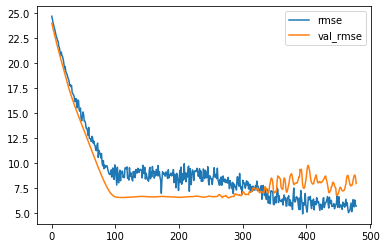

In [17]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [20]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

1/1 [==============================] - 0s 91ms/step - loss: 93.9588 - mse: 93.9588


array([9.69323403, 9.69323403])

In [18]:
np.sqrt(model.evaluate(val_ds.batch(batch_size)))

1/1 [==============================] - 0s 96ms/step - loss: 62.9902 - mse: 62.9902


array([7.93663897, 7.93663897])

In [19]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

1/1 [==============================] - 36s 36s/step - loss: 93.9588 - mse: 93.9588


array([9.69323403, 9.69323403])

In [ ]:
model.predict(preprocess_dataset([train_files[0]]).batch(30), verbose=2)

In [ ]:
model.predict(get_data(train_files[0])[0])

In [ ]:
get_data(train_files[5])[1]

In [ ]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [ ]:
meta.predict.describe()

In [ ]:
from sklearn.metrics import confusion_matrix, mean_squared_error
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

In [ ]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

In [ ]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

In [ ]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

In [ ]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [ ]:
model.save('saved_model/base_line/20210222')

In [ ]:
ls saved_model/base_line